## Data Exploration
Now that we have the data, let's load it up and take a look.

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import pandas as pd
print(f'Pandas {pd.__version__}')

Pandas 1.4.3


The competition recommends including external data sources and provides some 'starter' US census data in 'census_starter.csv'. But. I think we should start with just the training data and use it to set a baseline score that we can then try and improve upon by adding more data.

In [2]:
training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [3]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

Here are the column descriptions from the Kaggle competition site:
+ **row_id** - An ID code for the row.
+ **cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
+ **county_name** - The written name of the county.
+ **state_name** - The name of the state.
+ **first_day_of_month** - The date of the first day of the month.
+ **microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
+ **active** - The raw count of microbusinesses in the county. Not provided for the test set.

As stated above, we are going to use *microbusiness_density* only to start and then build from there. The plan being to predict the future microbusiness density from the past microbusiness density for each location.

Let's take a closer look at the microbusiness density data.

In [5]:
training_df['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

Looks like we have at least one zero and possibly one extreme high outlier. Let's check this out.

In [6]:
zero_count = (training_df['microbusiness_density'] == 0).sum()
zero_percent = (zero_count / len(training_df['microbusiness_density'])) * 100
print(f'Zero count: {zero_count} ({zero_percent:.2f}%)')

Zero count: 26 (0.02%)


In [7]:
zero_microbusiness_density = training_df[training_df['microbusiness_density'] == 0]
zero_microbusiness_density

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55632,28055_2021-02-01,28055,Issaquena County,Mississippi,2021-02-01,0.0,0
55633,28055_2021-03-01,28055,Issaquena County,Mississippi,2021-03-01,0.0,0
55634,28055_2021-04-01,28055,Issaquena County,Mississippi,2021-04-01,0.0,0
55635,28055_2021-05-01,28055,Issaquena County,Mississippi,2021-05-01,0.0,0
55636,28055_2021-06-01,28055,Issaquena County,Mississippi,2021-06-01,0.0,0
55637,28055_2021-07-01,28055,Issaquena County,Mississippi,2021-07-01,0.0,0
55638,28055_2021-08-01,28055,Issaquena County,Mississippi,2021-08-01,0.0,0
55639,28055_2021-09-01,28055,Issaquena County,Mississippi,2021-09-01,0.0,0
55640,28055_2021-10-01,28055,Issaquena County,Mississippi,2021-10-01,0.0,0
55641,28055_2021-11-01,28055,Issaquena County,Mississippi,2021-11-01,0.0,0


Looks like two counties had no microbusinesses for part of the dataset's date range. Presumably, some microbusinesses opened - hence the inclusion of these counties in the dataset. Let's take a look at Issaquena County to verify this explanation.

In [8]:
issaquena_county = training_df[training_df['county'] == 'Issaquena County']
issaquena_county.sort_values(by='first_day_of_month', ascending=True)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55614,28055_2019-08-01,28055,Issaquena County,Mississippi,2019-08-01,0.179372,2
55615,28055_2019-09-01,28055,Issaquena County,Mississippi,2019-09-01,0.179372,2
55616,28055_2019-10-01,28055,Issaquena County,Mississippi,2019-10-01,0.179372,2
55617,28055_2019-11-01,28055,Issaquena County,Mississippi,2019-11-01,0.179372,2
55618,28055_2019-12-01,28055,Issaquena County,Mississippi,2019-12-01,0.179372,2
55619,28055_2020-01-01,28055,Issaquena County,Mississippi,2020-01-01,0.177305,2
55620,28055_2020-02-01,28055,Issaquena County,Mississippi,2020-02-01,0.177305,2
55621,28055_2020-03-01,28055,Issaquena County,Mississippi,2020-03-01,0.177305,2
55622,28055_2020-04-01,28055,Issaquena County,Mississippi,2020-04-01,0.177305,2
55623,28055_2020-05-01,28055,Issaquena County,Mississippi,2020-05-01,0.177305,2


Ouch, sorry Issaquena County - we were right about their being non-zero values for part of the date range. But, instead of new microbusinesses opening looks like we started with 2 which both went out of business.

Either way, let's leave the zero values in for now.

Next, how about the extreme high value(s)?

In [9]:
training_df.nlargest(50, columns=['microbusiness_density'])

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011
94380,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245
122030,56033_2022-10-01,56033,Sheridan County,Wyoming,2022-10-01,227.756650,54509
68673,32510_2022-05-01,32510,Carson City,Nevada,2022-05-01,224.538250,98716
68670,32510_2022-02-01,32510,Carson City,Nevada,2022-02-01,217.587110,95660
68671,32510_2022-03-01,32510,Carson City,Nevada,2022-03-01,217.255020,95514
68672,32510_2022-04-01,32510,Carson City,Nevada,2022-04-01,217.141300,95464
68668,32510_2021-12-01,32510,Carson City,Nevada,2021-12-01,210.047300,91484
68669,32510_2022-01-01,32510,Carson City,Nevada,2022-01-01,208.227190,91545
68667,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.807650,90073


Ok, so these high values don't look like artifacts - seems like there are legitimately just some counties with lots of microbusinesses. I am willing to bet there is more to this part of the story - i.e. some legal or commercial reason why these are so many in these places. Going to leave them alone for now, but we may have to treat them differently in the end if the factors driving the high density are different from other places.

This is probably going to make our life difficult - it's a pretty long skinny tail on the distribution. Some of the high numbers are on the order of 20 - 40 sigma events...

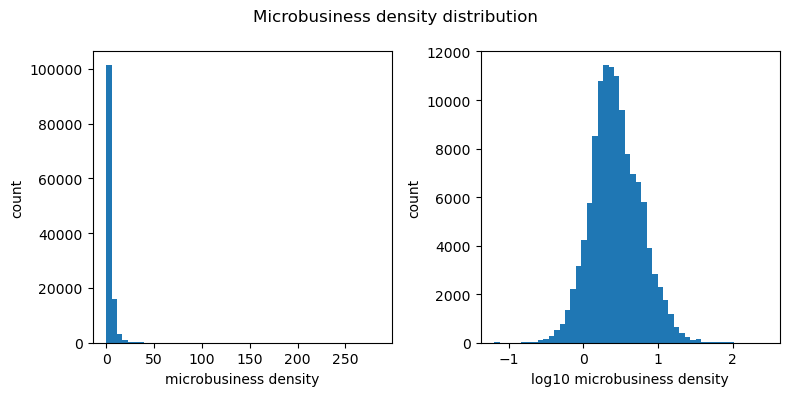

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get just microbusiness density
microbusiness_density = training_df['microbusiness_density']

# Remove zeros so we can plot the log
microbusiness_density = microbusiness_density[microbusiness_density > 0]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(microbusiness_density, bins=50)
ax[0].set_xlabel('microbusiness density')
ax[0].set_ylabel('count')

ax[1].hist(np.log10(microbusiness_density), bins=50)
ax[1].set_xlabel('log10 microbusiness density')
ax[1].set_ylabel('count')

plt.suptitle('Microbusiness density distribution')
plt.tight_layout()
plt.show()

In the plots above, each county is represented by multiple datapoints - one for each timepoint. Let's take a deeper look at the structure of the dataset in terms of the counties and the timeseries.

In [11]:
# Get list of counties in the dataset
counties = training_df['county']
counties.drop_duplicates(keep='first', inplace=True)
counties

0            Autauga County
39           Baldwin County
78           Barbour County
117             Bibb County
156           Blount County
                ...        
122031      Sublette County
122070    Sweetwater County
122148         Uinta County
122187      Washakie County
122226        Weston County
Name: county, Length: 1871, dtype: object

Ok, so 1871 counties in the dataset - next question, what is the timeseries range? and is there any missing data? i.e. do all of the counties have the same timepoints?

In [12]:
timepoints = training_df['first_day_of_month']
timepoints.drop_duplicates(keep='first', inplace=True)
timepoints

0    2019-08-01
1    2019-09-01
2    2019-10-01
3    2019-11-01
4    2019-12-01
5    2020-01-01
6    2020-02-01
7    2020-03-01
8    2020-04-01
9    2020-05-01
10   2020-06-01
11   2020-07-01
12   2020-08-01
13   2020-09-01
14   2020-10-01
15   2020-11-01
16   2020-12-01
17   2021-01-01
18   2021-02-01
19   2021-03-01
20   2021-04-01
21   2021-05-01
22   2021-06-01
23   2021-07-01
24   2021-08-01
25   2021-09-01
26   2021-10-01
27   2021-11-01
28   2021-12-01
29   2022-01-01
30   2022-02-01
31   2022-03-01
32   2022-04-01
33   2022-05-01
34   2022-06-01
35   2022-07-01
36   2022-08-01
37   2022-09-01
38   2022-10-01
Name: first_day_of_month, dtype: datetime64[ns]

Total unique timepoints in the dataset is 39. By manual inspection, we have one for each month between August 2019 and October 2022. Now, do we have all 39 rows for each county?

In [13]:
county_counts = training_df.groupby(['county']).size()
county_counts

county
Abbeville County              39
Acadia Parish                 39
Accomack County               39
Ada County                    39
Adair County                 156
                            ... 
Yukon-Koyukuk Census Area     39
Yuma County                   78
Zapata County                 39
Zavala County                 39
Ziebach County                39
Length: 1871, dtype: int64

Right off the bat, we have some counties with more than 39 rows of data. Let's split any counties with more or less than 39 rows into two separate lists so that we can take a look and try to figure out what is going on.

In [14]:
high_county_count = county_counts[county_counts > 39]
high_county_count

county
Adair County        156
Adams County        468
Albany County        78
Alexander County     78
Allegany County      78
                   ... 
Worth County        117
Wright County       117
Wyoming County      117
York County         195
Yuma County          78
Length: 423, dtype: int64

Looks like quite a few counties have more than 39. In fact I think I just figured out what is going on. Notice how counties which have more than 39 timepoints always have a number of timepoints which is a multiple of 39? I bet there are no counties with less than 39 timepoints...

In [15]:
low_county_count = county_counts[county_counts < 39]
low_county_count

Series([], dtype: int64)

Yep - pretty sure I know what's going on. We have some county names which appear in multiple states. To confirm, let's look at one county which has more than 39 rows associated with it.

In [16]:
adair_county = training_df[training_df['county'] == 'Adair County']
adair_counties = adair_county['state'].drop_duplicates(keep='first')
print(adair_counties)
adair_county

30693        Iowa
38649    Kentucky
57759    Missouri
82992    Oklahoma
Name: state, dtype: object


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
30693,19001_2019-08-01,19001,Adair County,Iowa,2019-08-01,2.782208,157
30694,19001_2019-09-01,19001,Adair County,Iowa,2019-09-01,2.746766,155
30695,19001_2019-10-01,19001,Adair County,Iowa,2019-10-01,2.782208,157
30696,19001_2019-11-01,19001,Adair County,Iowa,2019-11-01,2.870813,162
30697,19001_2019-12-01,19001,Adair County,Iowa,2019-12-01,2.853092,161
...,...,...,...,...,...,...,...
83026,40001_2022-06-01,40001,Adair County,Oklahoma,2022-06-01,0.975008,158
83027,40001_2022-07-01,40001,Adair County,Oklahoma,2022-07-01,0.968837,157
83028,40001_2022-08-01,40001,Adair County,Oklahoma,2022-08-01,0.968837,157
83029,40001_2022-09-01,40001,Adair County,Oklahoma,2022-09-01,0.981179,159


Yep, we have 4 Adair counties in Iowa, Kentucky, Missouri and Oklahoma. We counted 156 rows for Adair County and 4 x 39 = 156, so I think we solved it. We will have to be sure and use the cfips ID number to group by county in the future like so:

In [17]:
county_counts = training_df.groupby(['cfips']).size()
abnormal_county_count = county_counts[county_counts != 39]

print(f'Number of counties: {len(county_counts)}')
print(f'Counties with incorrect row count: {len(abnormal_county_count)}')

Number of counties: 3135
Counties with incorrect row count: 0


OK, great. No missing timepoints and we have quite a few more counties than we thought.

Next I want to visually inspect some of the data as a time series to get a feel for what it looks like.

In [18]:
westchester_NY_cfips = 36119
westchester_NY = training_df[training_df['cfips'] == westchester_NY_cfips]
westchester_NY

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
73476,36119_2019-08-01,36119,Westchester County,New York,2019-08-01,10.265532,77448
73477,36119_2019-09-01,36119,Westchester County,New York,2019-09-01,10.302513,77727
73478,36119_2019-10-01,36119,Westchester County,New York,2019-10-01,10.393705,78415
73479,36119_2019-11-01,36119,Westchester County,New York,2019-11-01,10.410406,78541
73480,36119_2019-12-01,36119,Westchester County,New York,2019-12-01,10.409081,78531
73481,36119_2020-01-01,36119,Westchester County,New York,2020-01-01,10.433874,78433
73482,36119_2020-02-01,36119,Westchester County,New York,2020-02-01,10.314281,77534
73483,36119_2020-03-01,36119,Westchester County,New York,2020-03-01,10.390773,78109
73484,36119_2020-04-01,36119,Westchester County,New York,2020-04-01,10.558656,79371
73485,36119_2020-05-01,36119,Westchester County,New York,2020-05-01,10.574753,79492


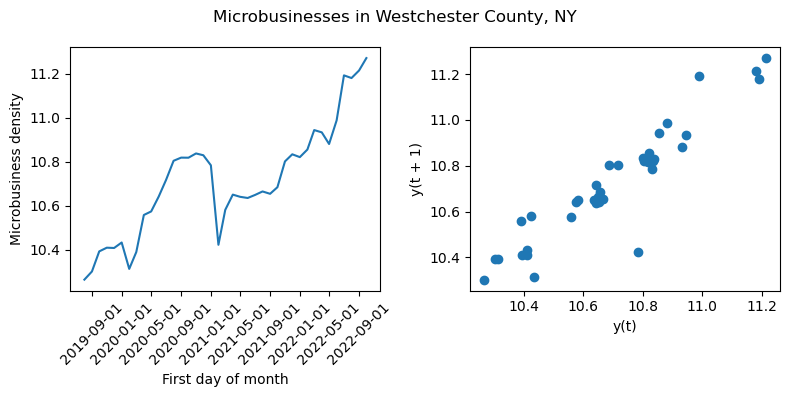

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(westchester_NY['first_day_of_month'], westchester_NY['microbusiness_density'])
ax[0].set_xlabel('First day of month')
ax[0].set_ylabel('Microbusiness density')

pd.plotting.lag_plot(westchester_NY['microbusiness_density'], lag=1, ax=ax[1])

#plt.draw()
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

plt.suptitle('Microbusinesses in Westchester County, NY')
plt.tight_layout()
plt.show()